In [1]:
import pandas as pd

In [12]:
df = pd.read_csv('../Data/sec_data/pivoted_financial_data_2010.csv')
print(f'DF shape: {df.shape}')

DF shape: (28385, 33)


In [13]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year >= 2010]
df = df[df['date'].dt.year < 2019]
print(f'DF shape: {df.shape}')
df.head()

DF shape: (15720, 33)


,ticker,date,AccumulatedOCI,Amortization,Assets,COGS,CapEx,CashAndEquivalents,CashFromOps,CurrentAssets,...,OperatingExpenses,OperatingIncome,PPE,RetainedEarnings,Revenue,RnD,SGA,ShareBasedComp,StockholdersEquity,WeightedShares
6,A,2010-01-31,-201000000.0,10000000.0,7.574000e+09,NaN,0.0,2.481000e+09,NaN,5.519000e+09,...,1.119000e+09,94000000.0,837000000.0,2.839000e+09,NaN,149000000.0,4.170000e+08,25000000.0,2.590000e+09,348.0
7,A,2010-04-30,-239000000.0,14000000.0,7.767000e+09,NaN,54000000.0,2.646000e+09,NaN,5.712000e+09,...,NaN,201000000.0,831000000.0,2.947000e+09,NaN,224500000.0,6.155000e+08,38000000.0,2.624000e+09,174000174.0
8,A,2010-07-31,NaN,36500000.0,NaN,NaN,87000000.0,2.317000e+09,NaN,NaN,...,NaN,239000000.0,NaN,NaN,NaN,303500000.0,8.680000e+08,51000000.0,NaN,347500000.0
9,A,2010-10-31,-88000000.0,76000000.0,9.696000e+09,NaN,121000000.0,2.649000e+09,NaN,6.169000e+09,...,NaN,566000000.0,980000000.0,3.444000e+09,5.444000e+09,612000000.0,1.752000e+09,66000000.0,3.228000e+09,347000000.0
10,A,2011-01-31,-63000000.0,28000000.0,8.044000e+09,NaN,0.0,2.638000e+09,NaN,4.598000e+09,...,NaN,211000000.0,982000000.0,3.637000e+09,NaN,159000000.0,4.460000e+08,28000000.0,3.332000e+09,173500173.5


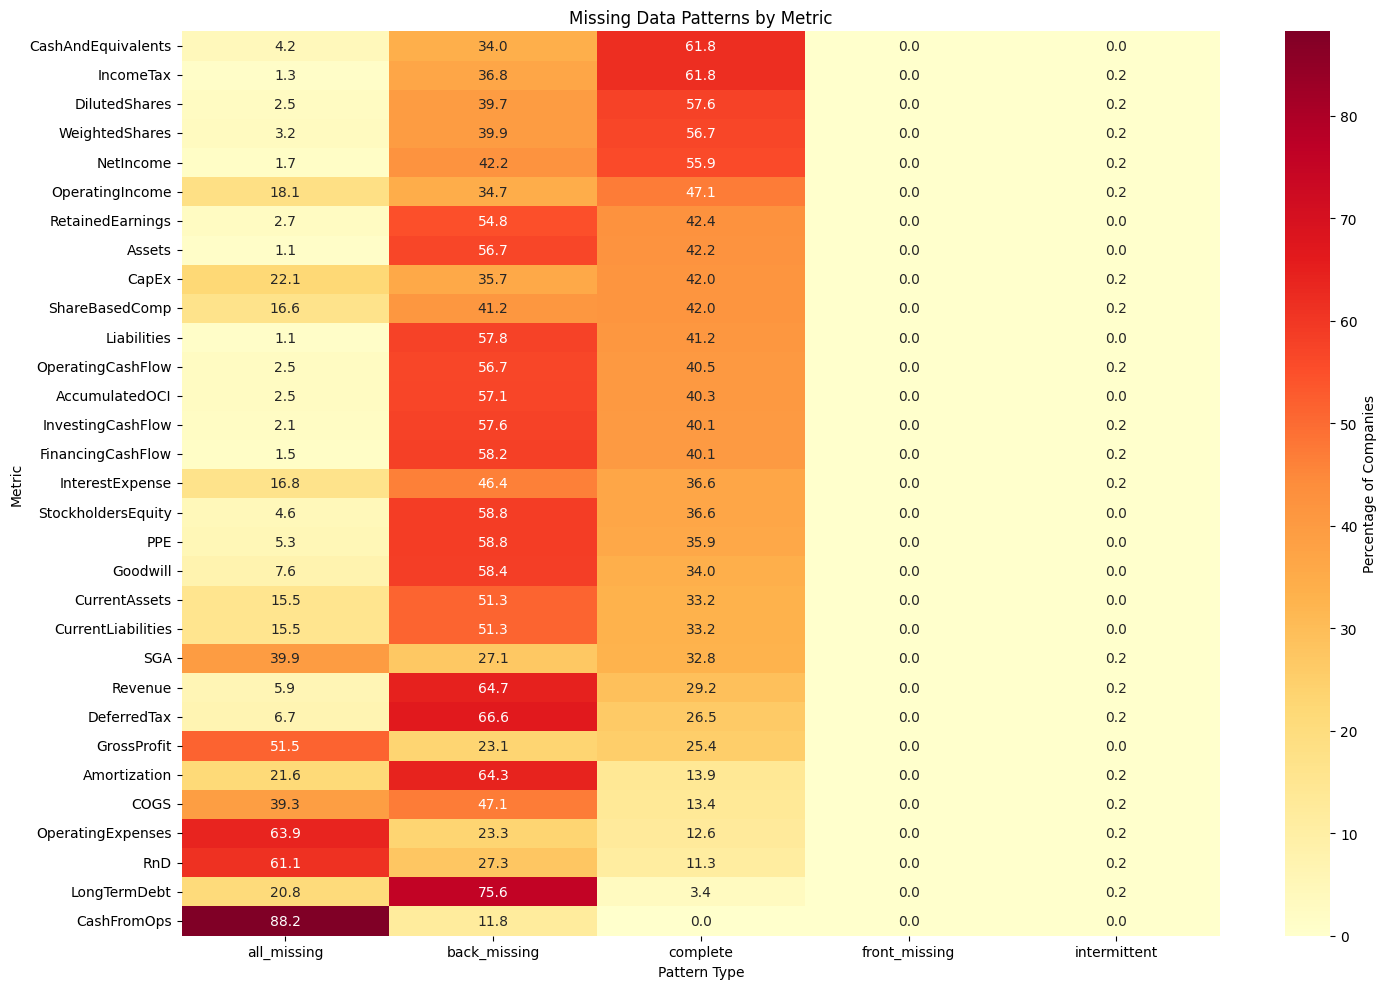

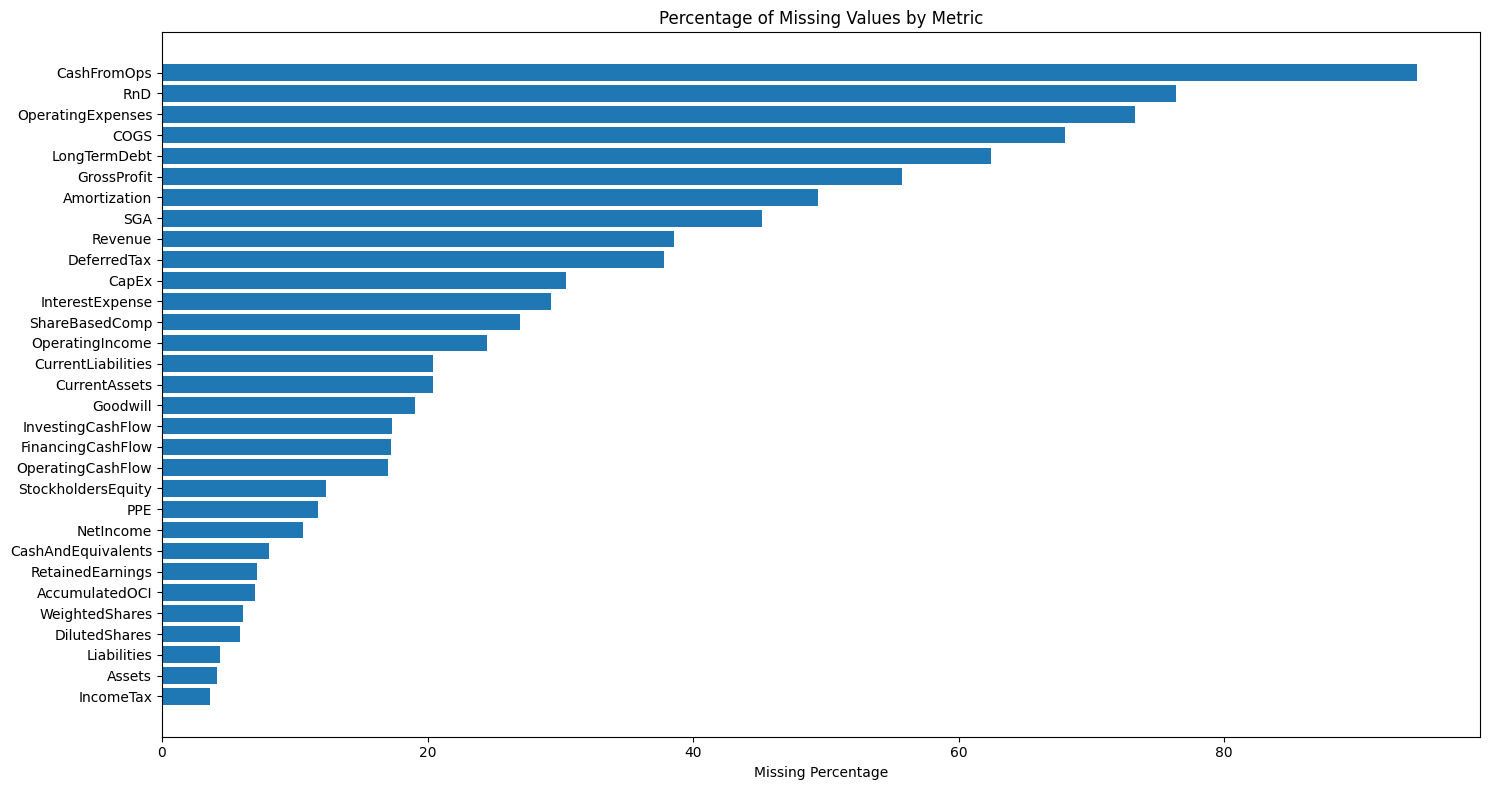

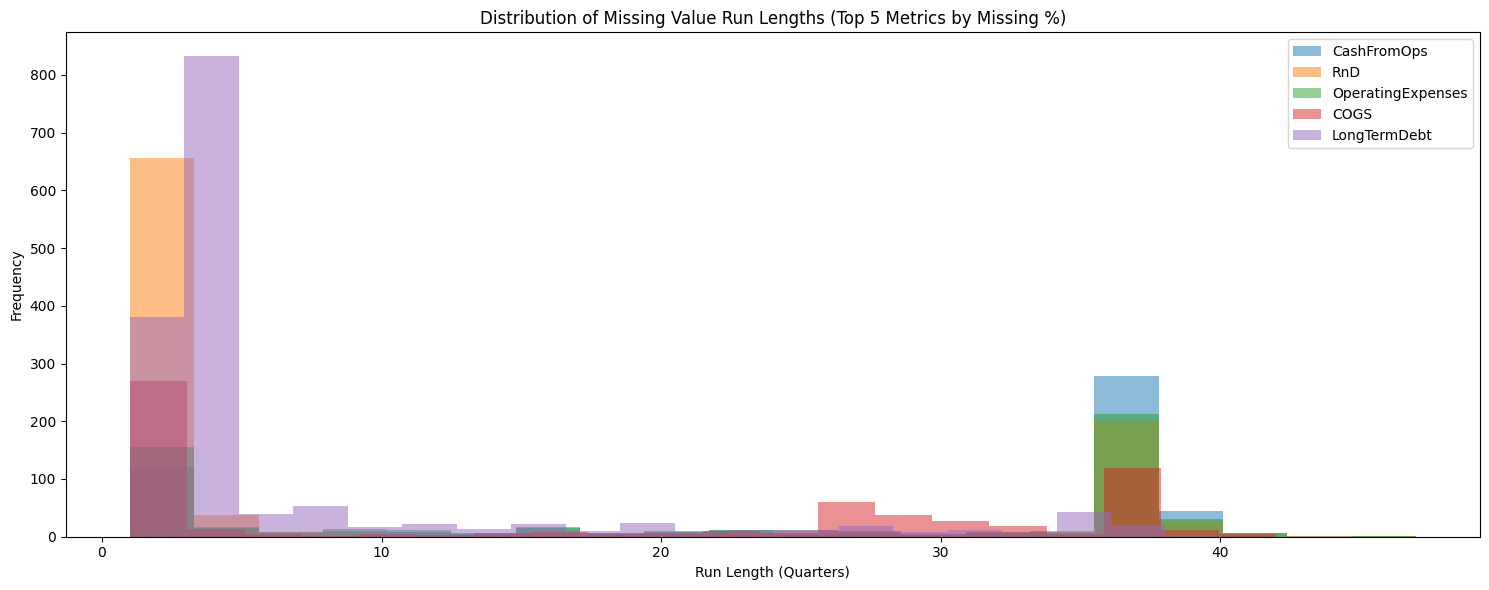


=== MISSING DATA ANALYSIS SUMMARY ===

METRICS ORDERED BY MISSING PERCENTAGE:
--------------------------------------------------

CashFromOps:
  Missing: 94.5%
  Companies affected: 476

  Pattern Distribution:
    complete: 0.0%
    front_missing: 0.0%
    back_missing: 11.8%
    intermittent: 0.0%
    all_missing: 88.2%

  Run Statistics:
    Average run length: 25.4 quarters
    Maximum run length: 47 quarters

RnD:
  Missing: 76.4%
  Companies affected: 422

  Pattern Distribution:
    complete: 11.3%
    front_missing: 0.0%
    back_missing: 27.3%
    intermittent: 0.2%
    all_missing: 61.1%

  Run Statistics:
    Average run length: 12.1 quarters
    Maximum run length: 47 quarters

OperatingExpenses:
  Missing: 73.2%
  Companies affected: 416

  Pattern Distribution:
    complete: 12.6%
    front_missing: 0.0%
    back_missing: 23.3%
    intermittent: 0.2%
    all_missing: 63.9%

  Run Statistics:
    Average run length: 21.8 quarters
    Maximum run length: 47 quarters

COGS:

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_missing_data(df):
    """
    Comprehensive analysis of missing data patterns
    """
    # Get metrics (excluding ticker and date)
    metrics = [col for col in df.columns if col not in ['ticker', 'date']]
    companies = df.groupby('ticker')
    n_companies = len(df['ticker'].unique())
    
    # Initialize results dictionary
    results = {
        'pattern_analysis': {},  # For pattern counts
        'run_analysis': {},      # For missing value runs
        'timeline_analysis': {}, # For when values are missing
        'company_patterns': defaultdict(dict)  # Store individual patterns
    }
    
    for metric in metrics:
        # Initialize metric stats
        results['pattern_analysis'][metric] = {
            'complete': 0,       # No missing values
            'front_missing': 0,  # Missing at start
            'back_missing': 0,   # Missing at end
            'intermittent': 0,   # Some values missing throughout
            'all_missing': 0     # All values missing
        }
        
        results['run_analysis'][metric] = {
            'max_run': 0,
            'avg_run': 0,
            'run_lengths': []
        }
        
        results['timeline_analysis'][metric] = {
            'total_missing': df[metric].isna().sum(),
            'missing_percentage': (df[metric].isna().sum() / len(df) * 100),
            'companies_affected': df.groupby('ticker')[metric].apply(lambda x: x.isna().any()).sum(),
            'quarterly_missing': df.groupby(df['date'])[metric].apply(lambda x: x.isna().sum()).to_dict()
        }
        
        # Analyze each company
        for ticker, company_data in companies:
            series = company_data[metric]
            missing = series.isna()
            
            # Store binary pattern
            pattern = ''.join(['0' if x else '1' for x in missing])
            results['company_patterns'][ticker][metric] = pattern
            
            # Classify pattern
            if not missing.any():
                results['pattern_analysis'][metric]['complete'] += 1
            elif missing.all():
                results['pattern_analysis'][metric]['all_missing'] += 1
            else:
                first_valid = series.first_valid_index()
                last_valid = series.last_valid_index()
                
                if first_valid is None or last_valid is None:
                    results['pattern_analysis'][metric]['intermittent'] += 1
                    continue
                
                front_missing = missing[:first_valid].all()
                back_missing = missing[last_valid+1:].all()
                middle_missing = missing[first_valid:last_valid+1].any()
                
                if front_missing and not back_missing and not middle_missing:
                    results['pattern_analysis'][metric]['front_missing'] += 1
                elif back_missing and not front_missing and not middle_missing:
                    results['pattern_analysis'][metric]['back_missing'] += 1
                else:
                    results['pattern_analysis'][metric]['intermittent'] += 1
            
            # Analyze runs of missing values
            current_run = 0
            for val in missing:
                if val:
                    current_run += 1
                elif current_run > 0:
                    results['run_analysis'][metric]['run_lengths'].append(current_run)
                    current_run = 0
            if current_run > 0:
                results['run_analysis'][metric]['run_lengths'].append(current_run)
        
        # Calculate run statistics
        runs = results['run_analysis'][metric]['run_lengths']
        if runs:
            results['run_analysis'][metric]['max_run'] = max(runs)
            results['run_analysis'][metric]['avg_run'] = np.mean(runs)
    
    return results

def visualize_missing_patterns(results):
    """
    Create visualizations for missing data patterns
    """
    # 1. Pattern Analysis Heatmap
    pattern_data = []
    for metric, patterns in results['pattern_analysis'].items():
        total = sum(patterns.values())
        for pattern_type, count in patterns.items():
            percentage = (count / total) * 100
            pattern_data.append({
                'Metric': metric,
                'Pattern': pattern_type,
                'Percentage': percentage
            })
    
    df_patterns = pd.DataFrame(pattern_data)
    pivot_table = df_patterns.pivot(index='Metric', columns='Pattern', values='Percentage')
    pivot_table = pivot_table.sort_values('complete', ascending=False)
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_table, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Percentage of Companies'})
    plt.title('Missing Data Patterns by Metric')
    plt.xlabel('Pattern Type')
    plt.ylabel('Metric')
    plt.tight_layout()
    plt.show()
    
    # 2. Timeline Analysis
    timeline_data = []
    for metric, stats in results['timeline_analysis'].items():
        timeline_data.append({
            'Metric': metric,
            'Missing Percentage': stats['missing_percentage'],
            'Companies Affected': stats['companies_affected']
        })
    
    df_timeline = pd.DataFrame(timeline_data)
    df_timeline = df_timeline.sort_values('Missing Percentage', ascending=True)
    
    plt.figure(figsize=(15, 8))
    plt.barh(df_timeline['Metric'], df_timeline['Missing Percentage'])
    plt.title('Percentage of Missing Values by Metric')
    plt.xlabel('Missing Percentage')
    plt.tight_layout()
    plt.show()
    
    # 3. Run Length Analysis
    plt.figure(figsize=(15, 6))
    # Get metrics with most missing values
    top_metrics = sorted(
        results['timeline_analysis'].items(),
        key=lambda x: x[1]['missing_percentage'],
        reverse=True
    )[:5]
    top_metric_names = [m[0] for m in top_metrics]
    
    for metric in top_metric_names:
        runs = results['run_analysis'][metric]['run_lengths']
        if runs:
            plt.hist(runs, alpha=0.5, label=metric, bins=20)
    plt.title('Distribution of Missing Value Run Lengths (Top 5 Metrics by Missing %)')
    plt.xlabel('Run Length (Quarters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_analysis_summary(results):
    """
    Print comprehensive analysis summary
    """
    print("\n=== MISSING DATA ANALYSIS SUMMARY ===\n")
    
    # Sort metrics by missing percentage
    metrics_by_missing = sorted(
        results['timeline_analysis'].items(),
        key=lambda x: x[1]['missing_percentage'],
        reverse=True
    )
    
    print("METRICS ORDERED BY MISSING PERCENTAGE:")
    print("-" * 50)
    for metric, stats in metrics_by_missing:
        print(f"\n{metric}:")
        print(f"  Missing: {stats['missing_percentage']:.1f}%")
        print(f"  Companies affected: {stats['companies_affected']}")
        
        # Pattern distribution
        patterns = results['pattern_analysis'][metric]
        total = sum(patterns.values())
        print("\n  Pattern Distribution:")
        for pattern, count in patterns.items():
            print(f"    {pattern}: {count/total*100:.1f}%")
        
        # Run analysis
        run_stats = results['run_analysis'][metric]
        if run_stats['run_lengths']:
            print("\n  Run Statistics:")
            print(f"    Average run length: {run_stats['avg_run']:.1f} quarters")
            print(f"    Maximum run length: {run_stats['max_run']} quarters")
    
    print("\n=== END OF ANALYSIS ===")

results = analyze_missing_data(df)
visualize_missing_patterns(results)
print_analysis_summary(results)

In [20]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_consolidated_features(df):
    """
    Create final features DataFrame with one row per company
    """
    # Dictionary to store features for each company
    company_features = {}
    
    # Group by company
    for ticker, company_data in df.groupby('ticker'):
        features = {}
        
        # Helper function for safe calculations
        def safe_mean(series):
            return np.mean(series) if not series.empty and not all(series.isna()) else np.nan
            
        def safe_std(series):
            return np.std(series) if not series.empty and len(series.dropna()) > 1 else np.nan
            
        def safe_cagr(series):
            series = series.dropna()
            if len(series) < 2:
                return np.nan
            start_val = series.iloc[0]
            end_val = series.iloc[-1]
            if start_val <= 0 or end_val <= 0:
                return np.nan
            n_periods = len(series) - 1
            return (end_val/start_val)**(1/n_periods) - 1
        
        def safe_trend(series):
            series = series.dropna()
            if len(series) < 2:
                return np.nan
            x = np.arange(len(series))
            slope, _, _, _, _ = stats.linregress(x, series)
            return slope

        # 1. Core Financial Ratios
        # ROA
        features['avg_roa'] = safe_mean(company_data['NetIncome'] / company_data['Assets'])
        features['roa_volatility'] = safe_std(company_data['NetIncome'] / company_data['Assets'])
        
        # ROE
        features['avg_roe'] = safe_mean(company_data['NetIncome'] / company_data['StockholdersEquity'])
        features['roe_volatility'] = safe_std(company_data['NetIncome'] / company_data['StockholdersEquity'])
        
        # Asset Turnover
        features['avg_asset_turnover'] = safe_mean(company_data['Revenue'] / company_data['Assets'])
        
        # Current Ratio
        features['avg_current_ratio'] = safe_mean(company_data['CurrentAssets'] / company_data['CurrentLiabilities'])
        
        # Leverage
        features['avg_leverage'] = safe_mean(company_data['Liabilities'] / company_data['Assets'])
        features['avg_debt_to_equity'] = safe_mean(company_data['LongTermDebt'] / company_data['StockholdersEquity'])
        
        # 2. Growth Metrics
        features['cagr_revenue'] = safe_cagr(company_data['Revenue'])
        features['cagr_assets'] = safe_cagr(company_data['Assets'])
        features['cagr_operating_income'] = safe_cagr(company_data['OperatingIncome'])
        
        # 3. Trend Metrics
        features['revenue_trend'] = safe_trend(company_data['Revenue'])
        features['income_trend'] = safe_trend(company_data['NetIncome'])
        features['asset_trend'] = safe_trend(company_data['Assets'])
        
        # 4. Volatility Metrics
        features['income_volatility'] = safe_std(company_data['NetIncome'] / company_data['Assets'])
        features['revenue_volatility'] = safe_std(company_data['Revenue'].pct_change())
        features['margin_volatility'] = safe_std(company_data['OperatingIncome'] / company_data['Revenue'])
        
        # 5. Operating Metrics
        features['avg_margin'] = safe_mean(company_data['OperatingIncome'] / company_data['Revenue'])
        features['capex_intensity'] = safe_mean(company_data['CapEx'] / company_data['Revenue'])
        features['working_cap_ratio'] = safe_mean((company_data['CurrentAssets'] - company_data['CurrentLiabilities']) / company_data['Assets'])
        
        # 6. Quality & Structure Indicators
        features['has_rnd'] = 1 if not company_data['RnD'].isna().all() else 0
        features['has_goodwill'] = 1 if not company_data['Goodwill'].isna().all() else 0
        features['has_ltdebt'] = 1 if not company_data['LongTermDebt'].isna().all() else 0
        
        # 7. Size
        features['avg_size'] = safe_mean(np.log(company_data['Assets']))
        
        # 8. Data Quality
        core_metrics = ['Assets', 'Revenue', 'NetIncome', 'OperatingIncome', 'StockholdersEquity']
        features['data_completeness'] = 1 - (company_data[core_metrics].isna().sum().sum() / (len(company_data) * len(core_metrics)))
        
        company_features[ticker] = features
    
    # Convert to DataFrame
    final_df = pd.DataFrame.from_dict(company_features, orient='index')
    
    # Add feature indicating number of quarters of data
    quarters_data = df.groupby('ticker').size()
    final_df['num_quarters'] = quarters_data
    
    return final_df

# Example usage:
final_df = calculate_consolidated_features(df)

# Print summary statistics and data quality info
print("\nFinal Dataset Shape:", final_df.shape)
print("\nMissing Values Summary:")
print(final_df.isna().sum().sort_values(ascending=False))
print("\nFeature Summary Statistics:")
print(final_df.describe())

# Optionally save to CSV
final_df.to_csv('consolidated_features.csv')

/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['revenue_volatility'] = safe_std(company_data['Revenue'].pct_change())
/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['revenue_volatility'] = safe_std(company_data['Revenue'].pct_change())
/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N


Final Dataset Shape: (476, 26)

Missing Values Summary:
cagr_operating_income    140
capex_intensity          131
avg_debt_to_equity       117
margin_volatility        116
avg_margin               104
working_cap_ratio         74
avg_current_ratio         74
cagr_revenue              42
revenue_volatility        42
revenue_trend             36
roe_volatility            35
avg_asset_turnover        29
avg_roe                   27
roa_volatility            16
income_volatility         16
income_trend              11
avg_roa                   10
cagr_assets               10
asset_trend               10
avg_leverage               5
avg_size                   5
has_rnd                    0
has_goodwill               0
has_ltdebt                 0
data_completeness          0
num_quarters               0
dtype: int64

Feature Summary Statistics:
             avg_roa  roa_volatility       avg_roe  roe_volatility  \
count     466.000000    4.600000e+02  4.490000e+02    4.410000e+02   
mean   

/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['revenue_volatility'] = safe_std(company_data['Revenue'].pct_change())
/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['revenue_volatility'] = safe_std(company_data['Revenue'].pct_change())
/tmp/ipykernel_22270/3295246918.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

In [35]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_missing_patterns(df):
    """
    Analyze and create features from missing data patterns
    """
    # Define key metric groups
    key_metrics = {
        'structural': ['RnD', 'Goodwill', 'LongTermDebt'],
        'core': ['Revenue', 'NetIncome', 'Assets', 'OperatingIncome'],
        'operational': ['CapEx', 'CurrentAssets', 'CurrentLiabilities']
    }
    
    companies = df.groupby('ticker')
    patterns = {}
    
    for ticker, company_data in companies:
        patterns[ticker] = {}
        
        # 1. Structural patterns (never/always missing)
        for metric in key_metrics['structural']:
            patterns[ticker][f'has_{metric.lower()}'] = not company_data[metric].isna().all()
        
        # 2. Core metric completeness
        core_completeness = 1 - company_data[key_metrics['core']].isna().mean().mean()
        patterns[ticker]['core_completeness'] = core_completeness
        
        # 3. Reporting patterns
        for metric in key_metrics['core'] + key_metrics['operational']:
            metric_data = company_data[metric].reset_index(drop=True)
            not_null = ~metric_data.isna()
            if not_null.any():
                first_reported = not_null.idxmax()
                # Calculate when reporting starts as a percentage of total time
                patterns[ticker][f'{metric}_start'] = first_reported / len(metric_data)
            else:
                patterns[ticker][f'{metric}_start'] = -1
        
        # 4. Overall reporting quality
        patterns[ticker]['reporting_consistency'] = 1 - (company_data[key_metrics['core']].isna().sum().sum() / 
                                                       (len(company_data) * len(key_metrics['core'])))
    
    return pd.DataFrame.from_dict(patterns, orient='index')

def calculate_raw_ratios(df):
    """
    Calculate financial ratios without imputation
    """
    ratios = pd.DataFrame(index=df.index)
    
    # Profitability ratios
    ratios['ROA'] = df['NetIncome'] / df['Assets']
    ratios['ROE'] = df['NetIncome'] / df['StockholdersEquity']
    ratios['OperatingMargin'] = df['OperatingIncome'] / df['Revenue']
    
    # Efficiency ratios
    ratios['AssetTurnover'] = df['Revenue'] / df['Assets']
    ratios['CurrentRatio'] = df['CurrentAssets'] / df['CurrentLiabilities']
    
    # Leverage ratios
    ratios['Leverage'] = df['Liabilities'] / df['Assets']
    ratios['DebtToEquity'] = df['LongTermDebt'] / df['StockholdersEquity']
    
    return ratios

def create_base_features(df, ratios):
    """
    Create consolidated features while preserving missing values
    """
    companies = df.groupby('ticker')
    features = {}
    
    for ticker, company_data in companies:
        features[ticker] = {}
        
        # 1. Average ratios (no imputation)
        for col in ratios.columns:
            company_ratios = ratios.loc[company_data.index, col]
            features[ticker][f'avg_{col}'] = company_ratios.mean()
            features[ticker][f'{col}_volatility'] = company_ratios.std()
        
        # 2. Growth rates
        for metric in ['Revenue', 'Assets', 'NetIncome']:
            if not company_data[metric].isna().all():
                clean_data = company_data[metric].dropna()
                if len(clean_data) > 1:
                    start_val = clean_data.iloc[0]
                    end_val = clean_data.iloc[-1]
                    if start_val > 0 and end_val > 0:
                        features[ticker][f'{metric}_growth'] = (end_val/start_val)**(1/len(clean_data)) - 1
                    else:
                        features[ticker][f'{metric}_growth'] = np.nan
                else:
                    features[ticker][f'{metric}_growth'] = np.nan
            else:
                features[ticker][f'{metric}_growth'] = np.nan
        
        # 3. Size and scale
        features[ticker]['log_assets'] = np.log(company_data['Assets'].mean()) if not company_data['Assets'].isna().all() else np.nan
        
        # 4. Operating characteristics
        if not company_data['CapEx'].isna().all() and not company_data['Revenue'].isna().all():
            features[ticker]['capex_intensity'] = (company_data['CapEx'] / company_data['Revenue']).mean()
        else:
            features[ticker]['capex_intensity'] = np.nan
            
    return pd.DataFrame.from_dict(features, orient='index')

def impute_final_features(feature_df, pattern_df):
    """
    Impute missing values in final feature set
    """
    df = feature_df.copy()
    
    # 1. Size-based grouping for more accurate imputation
    df['size_category'] = pd.qcut(df['log_assets'].fillna(df['log_assets'].median()), 
                                q=5, labels=['vs', 's', 'm', 'l', 'vl'])
    
    # 2. Impute different feature groups
    # Ratio features - median within size category
    ratio_features = [col for col in df.columns if col.startswith(('avg_', 'ROA', 'ROE'))]
    for col in ratio_features:
        df[col] = df.groupby('size_category')[col].transform(
            lambda x: x.fillna(x.median())
        )
    
    # Growth features - 0 imputation with flag
    growth_features = [col for col in df.columns if 'growth' in col]
    for col in growth_features:
        df[f'{col}_imputed'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(0)
    
    # Volatility features - median imputation
    vol_features = [col for col in df.columns if 'volatility' in col]
    for col in vol_features:
        df[col] = df[col].fillna(df[col].median())
    
    # 3. Remove temporary columns
    df = df.drop('size_category', axis=1)
    
    # 4. Combine with pattern features
    df = pd.concat([df, pattern_df], axis=1)
    
    return df

def create_final_dataset(df):
    """
    Main function to create final feature set
    """
    # 1. Analyze missing patterns
    print("Analyzing missing patterns...")
    pattern_features = analyze_missing_patterns(df)
    
    # 2. Calculate raw ratios
    print("Calculating financial ratios...")
    raw_ratios = calculate_raw_ratios(df)
    
    # 3. Create base features
    print("Creating base features...")
    base_features = create_base_features(df, raw_ratios)
    
    # 4. Final imputation and combination
    print("Performing final imputation...")
    final_features = impute_final_features(base_features, pattern_features)
    
    print("\nFinal dataset shape:", final_features.shape)
    print("\nFeature groups:")
    print("Financial ratios:", len([col for col in final_features.columns if col.startswith('avg_')]))
    print("Growth metrics:", len([col for col in final_features.columns if 'growth' in col]))
    print("Missing patterns:", len([col for col in final_features.columns if col in pattern_features.columns]))
    print("Imputation flags:", len([col for col in final_features.columns if 'imputed' in col]))
    
    return final_features

Analyzing missing patterns...
Calculating financial ratios...
Creating base features...


/home/mireg/Repos/thesis_clustering_portfolio/thesis_venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/mireg/Repos/thesis_clustering_portfolio/thesis_venv/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Performing final imputation...

Final dataset shape: (476, 34)

Feature groups:
Financial ratios: 7
Growth metrics: 6
Missing patterns: 12
Imputation flags: 3

Missing values after processing:
log_assets           5
capex_intensity    131
dtype: int64


/tmp/ipykernel_22270/3962606230.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('size_category')[col].transform(
/tmp/ipykernel_22270/3962606230.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('size_category')[col].transform(
/tmp/ipykernel_22270/3962606230.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('size_category')[col].transform(
/tmp

In [38]:
final_df.info()
final_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, A to ZMH
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   avg_ROA                     476 non-null    float64
 1   ROA_volatility              476 non-null    float64
 2   avg_ROE                     476 non-null    float64
 3   ROE_volatility              476 non-null    float64
 4   avg_OperatingMargin         476 non-null    float64
 5   OperatingMargin_volatility  476 non-null    float64
 6   avg_AssetTurnover           476 non-null    float64
 7   AssetTurnover_volatility    476 non-null    float64
 8   avg_CurrentRatio            476 non-null    float64
 9   CurrentRatio_volatility     476 non-null    float64
 10  avg_Leverage                476 non-null    float64
 11  Leverage_volatility         476 non-null    float64
 12  avg_DebtToEquity            476 non-null    float64
 13  DebtToEquity_volatility     476 non-null

avg_ROA                       float64
ROA_volatility                float64
avg_ROE                       float64
ROE_volatility                float64
avg_OperatingMargin           float64
OperatingMargin_volatility    float64
avg_AssetTurnover             float64
AssetTurnover_volatility      float64
avg_CurrentRatio              float64
CurrentRatio_volatility       float64
avg_Leverage                  float64
Leverage_volatility           float64
avg_DebtToEquity              float64
DebtToEquity_volatility       float64
Revenue_growth                float64
Assets_growth                 float64
NetIncome_growth              float64
log_assets                    float64
capex_intensity               float64
Revenue_growth_imputed          int64
Assets_growth_imputed           int64
NetIncome_growth_imputed        int64
has_rnd                          bool
has_goodwill                     bool
has_longtermdebt                 bool
core_completeness             float64
Revenue_star

In [41]:
for col in final_df.columns:
    if col.startswith('has_'):
        final_df[col] = final_df[col].astype(int)
final_df.dtypes

avg_ROA                       float64
ROA_volatility                float64
avg_ROE                       float64
ROE_volatility                float64
avg_OperatingMargin           float64
OperatingMargin_volatility    float64
avg_AssetTurnover             float64
AssetTurnover_volatility      float64
avg_CurrentRatio              float64
CurrentRatio_volatility       float64
avg_Leverage                  float64
Leverage_volatility           float64
avg_DebtToEquity              float64
DebtToEquity_volatility       float64
Revenue_growth                float64
Assets_growth                 float64
NetIncome_growth              float64
log_assets                    float64
capex_intensity               float64
Revenue_growth_imputed          int64
Assets_growth_imputed           int64
NetIncome_growth_imputed        int64
has_rnd                         int64
has_goodwill                    int64
has_longtermdebt                int64
core_completeness             float64
Revenue_star

In [3]:
import pandas as pd
df_test = pd.read_csv('../Data/processed/financial_features_2010.csv')
df_test.dtypes

Unnamed: 0                     object
avg_ROA                       float64
ROA_volatility                float64
avg_ROE                       float64
ROE_volatility                float64
avg_OperatingMargin           float64
OperatingMargin_volatility    float64
avg_AssetTurnover             float64
AssetTurnover_volatility      float64
avg_CurrentRatio              float64
CurrentRatio_volatility       float64
avg_Leverage                  float64
Leverage_volatility           float64
avg_DebtToEquity              float64
DebtToEquity_volatility       float64
Revenue_growth                float64
Assets_growth                 float64
NetIncome_growth              float64
log_assets                    float64
capex_intensity               float64
Revenue_growth_imputed          int64
Assets_growth_imputed           int64
NetIncome_growth_imputed        int64
capex_intensity_imputed         int64
has_rnd                         int64
has_goodwill                    int64
has_longterm